In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
%pwd

import torch
from train import load_cifar_data, get_args_parser

# device = torch.device("cpu")

device = torch.device("cuda")


args = get_args_parser().parse_args([])

args.distributed = False
args.dataset = "cifar10"
args.data_path = "./data/"
args.batch_size = 128
args.device = device
args.range = 5.

_, dataset_test, _, test_sampler = load_cifar_data(args)

num_classes = len(dataset_test.classes)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=args.batch_size, sampler=test_sampler, num_workers=args.workers, pin_memory=True
)


/home/lprfenau/ppml-using-poly-relus/ml
Loading data
Loading training data
Files already downloaded and verified
Took 0.696861743927002
Loading validation data
Files already downloaded and verified
Creating data loaders


In [2]:

import numpy as np
import scipy.stats

#https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
    return m, m - h, m + h

def set_dict_entry(dictionary, keys, value):
    for key in keys[:-1]:
        dictionary = dictionary.setdefault(key, {})
    dictionary[keys[-1]] = value

def dict_iterator(dictionary, keys=None):
    if keys is None:
        keys = []
    for key, value in dictionary.items():
        new_keys = keys + [key]
        if isinstance(value, dict):
            for pair in dict_iterator(value, keys=new_keys):
                yield pair
        else:
            yield [new_keys, value]

def get_CI(dictionary):
    to_return = {}
    for val in dict_iterator(dictionary):
        utilities = val[1]
        set_dict_entry(to_return, val[0], mean_confidence_interval(utilities))
    return to_return

In [3]:
import os
from PolyRelu import get_metrics, real_relu, generate_coeffs, PolyRelu
from utils import strip
from resnet_x import ConvNet
import matplotlib.pyplot as plt

degrees = []
best_accuracies = []
associated_oor = []

degree = 4

reg_coeffs = (0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001)
model_nums = (1, 2, 3, 4, 5)

acc_low = []
acc_up = []
acc_mean = []
oor_low = []
oor_up = []
oor_mean = []
reg_coef_list = []
found = [True]*len(reg_coeffs)

for i, reg_coef in enumerate(reg_coeffs):
    c_accuracies = []
    c_oor_percentages = []
    c_oor_maxs = []
    for j, model_num in enumerate(model_nums):
        if reg_coef != 0.1:
            str_reg_coef = ("%.17f" % reg_coef).rstrip('0').rstrip('.')
        else:
            str_reg_coef = str(reg_coef)
        if model_num is None:
            output_dir = f"./experiments/figure_3/convnet_pr_degree_{degree}_reg_coef_{str_reg_coef}/"  # replace it with whatever you set as output directory
        else:
            output_dir = f"./experiments/figure_3/convnet_pr_degree_{degree}_reg_coef_{str_reg_coef}_{model_num}/"  # replace it with whatever you set as output directory
        print(output_dir)
        try:
            # we now load the checkpoint
            best_checkpoint = torch.load(output_dir+"best_model.pth", map_location="cpu")
        except FileNotFoundError:
            found[i] = False
            continue

        c_accuracies.append(best_checkpoint["best_acc"])
        model = ConvNet(num_classes=num_classes)
        model.load_state_dict(best_checkpoint["model"])

        # swap it to PolyRelus

        PolyRelu.reset_ids()
        PolyRelu.reset()  # in case this cell is re-run

        if not os.path.exists("./poly_coefs"):
            os.mkdir(os.path.join("./poly_coefs"))
        coeffs = generate_coeffs(real_relu, degree=degree, file_prefix="./poly_coefs", rng=args.range,
                                 quantized_coef=0)  #
        module = PolyRelu(coeffs, range=args.range, alpha=0., regularize=True)  # a polynomial relu that saves the inputs it gets fed

        strip(model, "relu", module, torch.nn.ReLU)

        model = model.to(device)

        model.eval()

        metrics = get_metrics(dataloader=data_loader_test, model=model, device=device, input_range=(-args.range, args.range),
            metrics=["oor_percentage", 'oor_max', 'oor_values'])

        c_oor_percentages.append(metrics["oor_percentage"])
        c_oor_maxs.append(metrics["oor_max"].cpu().numpy())
    m, l, u = mean_confidence_interval(c_accuracies)
    m_p, l_p, u_p = mean_confidence_interval(c_oor_percentages)
    acc_mean.append(m)
    acc_low.append(l)
    acc_up.append(u)
    oor_mean.append(m_p)
    oor_low.append(l_p)
    oor_up.append(u_p)
    reg_coef_list.append(reg_coef)


./experiments/figure_3/convnet_pr_degree_4_reg_coef_0.1_1/
Out of range distribution information
OOR Max: 4.333
No OOR value so cannot compute mean or standard deviation
Nan count: 0
Acc: 52.2599983215332
Out of Range %: 0.0
./experiments/figure_3/convnet_pr_degree_4_reg_coef_0.1_2/
Out of range distribution information
OOR Max: 4.375
No OOR value so cannot compute mean or standard deviation
Nan count: 0
Acc: 39.73999786376953
Out of Range %: 0.0
./experiments/figure_3/convnet_pr_degree_4_reg_coef_0.1_3/
Out of range distribution information
OOR Max: 4.132
No OOR value so cannot compute mean or standard deviation
Nan count: 0
Acc: 31.67999839782715
Out of Range %: 0.0
./experiments/figure_3/convnet_pr_degree_4_reg_coef_0.1_4/
Out of range distribution information
OOR Max: 5.638
OOR Mean: 5.638
OOR Std: 0.000
Nan count: 0
Acc: 36.349998474121094
Out of Range %: 1.5566625211071994e-06
./experiments/figure_3/convnet_pr_degree_4_reg_coef_0.1_5/
Out of range distribution information
OOR Max

[44.547999999999995, 46.184000000000005, 61.84599999999999, 66.21799999999999, 67.78800000000001, 72.112, 70.312, 60.992000000000004] [28.779183996966648, 31.134139538076916, 49.27224490562057, 54.50514124278392, 56.35481143861459, 70.26328781156016, 69.60788782831861, 59.10233587812797] [60.31681600303334, 61.23386046192309, 74.41975509437941, 77.93085875721606, 79.22118856138543, 73.96071218843983, 71.01611217168139, 62.88166412187204]


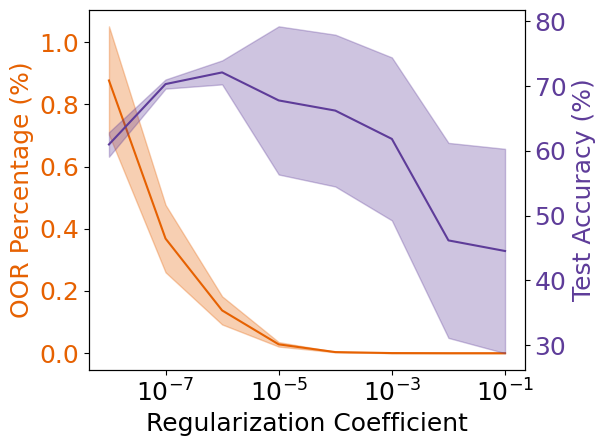

In [4]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 18})

print(acc_mean, acc_low, acc_up)
fig, ax1 = plt.subplots()
color = '#e66101'
ax1.set_xlabel('Regularization Coefficient')
ax1.set_ylabel("OOR Percentage (%)", color=color)
ax1.plot(reg_coef_list, oor_mean, color=color)
ax1.fill_between(reg_coef_list, oor_low, oor_up, alpha=0.3, color=color)

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = '#5e3c99'
ax2.set_xlabel("Regularization Coefficient")
ax2.set_ylabel("Test Accuracy (%)", color=color)
ax2.plot(reg_coef_list, acc_mean, color=color)
ax2.fill_between(reg_coef_list, acc_low, acc_up, alpha=0.3, color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale('log')

fig.tight_layout()
plt.savefig("figure_3.pdf", bbox_inches='tight')
plt.show()